In [1]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AdamW, get_linear_schedule_with_warmup
import time
import random

/usr4/cs585bp/phamquan/.local/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
print('Done!')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Loading BERT tokenizer...
Done!


In [3]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
validation_dataloader = DataLoader(test_dataset, batch_size=8)

In [4]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda:0")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    print('Device name:', torch.cuda.get_device_name(1))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla V100-PCIE-16GB
Device name: Tesla V100-PCIE-16GB


In [5]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 1024, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-large-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [6]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        bert_classifier = torch.nn.DataParallel(bert_classifier)
    
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5, # Default 5e-5
                      eps=1e-8)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    
    return bert_classifier, optimizer, scheduler

In [7]:
loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Training loop
def train(model, train_dataloader, validation_dataloader=None, epochs=1, evaluation=False):
    training_stats = {
        'train_loss': [],
        'validation_loss': [],
        'validation_acc': []
    }
    
    print("Start training...\n")
    for epoch_i in range(epochs):
        # Print the header of the result table


        # Measure the elapsed time of each epoch
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_i+1}")):
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch["label"]
            b_input_ids, b_attn_mask, b_labels = b_input_ids.to(device), b_attn_mask.to(device), b_labels.to(device)

            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        training_stats['train_loss'].append(avg_train_loss)
        time_elapsed = time.time() - t0_epoch
        
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Elapsed':^9}")
        print("-" * 45)
        # Print training results
        print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {time_elapsed:^9.2f}")
        print("-" * 45)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation:
            val_loss, val_accuracy = evaluate(model, validation_dataloader)
            training_stats['validation_loss'].append(val_loss)
            training_stats['validation_acc'].append(val_accuracy)
            
            print(f"{'Val Loss':^10} | {'Val Acc':^9}")
            print(f"{val_loss:^10.6f} | {val_accuracy:^9.2f}")
            print("-" * 25)

    print("\nTraining complete!")
    return training_stats

# Evaluation loop
def evaluate(model, val_dataloader):
    """
    Measure the model's performance on the validation set.
    """
    model.eval()
    val_accuracy = []
    val_loss = []

    for batch in tqdm(val_dataloader, desc="Running validation ..."):
        b_input_ids, b_attn_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch["label"]
        b_input_ids, b_attn_mask, b_labels = b_input_ids.to(device), b_attn_mask.to(device), b_labels.to(device)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())

            preds = torch.argmax(logits, dim=1).flatten()
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [8]:
set_seed(42)    # Set seed for reproducibility
num_epochs = 10

bert_classifier, optimizer, scheduler = initialize_model(epochs=num_epochs)
train_stats = train(bert_classifier, 
                    train_dataloader, 
                    validation_dataloader, 
                    epochs=num_epochs, 
                    evaluation=True)

Using 2 GPUs!


/usr4/cs585bp/phamquan/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...



Epoch 1: 100%|██████████| 3125/3125 [38:45<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   1    |   0.297165   |  2325.56 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:36<00:00,  3.56it/s]


 Val Loss  |  Val Acc 
 0.254989  |   93.44  
-------------------------


Epoch 2: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   2    |   0.175649   |  2323.78 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.243104  |   94.02  
-------------------------


Epoch 3: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   3    |   0.095716   |  2323.51 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.340289  |   93.84  
-------------------------


Epoch 4: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   4    |   0.055711   |  2323.88 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.346595  |   94.39  
-------------------------


Epoch 5: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   5    |   0.039201   |  2323.57 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.355619  |   94.26  
-------------------------


Epoch 6: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   6    |   0.028752   |  2323.63 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.362423  |   94.40  
-------------------------


Epoch 7: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   7    |   0.020090   |  2323.64 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.447799  |   93.87  
-------------------------


Epoch 8: 100%|██████████| 3125/3125 [38:44<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   8    |   0.013527   |  2324.60 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.447842  |   94.23  
-------------------------


Epoch 9: 100%|██████████| 3125/3125 [38:44<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
   9    |   0.008932   |  2324.20 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


 Val Loss  |  Val Acc 
 0.426967  |   94.52  
-------------------------


Epoch 10: 100%|██████████| 3125/3125 [38:43<00:00,  1.34it/s]


 Epoch  |  Train Loss  |  Elapsed 
---------------------------------------------
  10    |   0.005321   |  2323.54 
---------------------------------------------


Running validation ...: 100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]

 Val Loss  |  Val Acc 
 0.438145  |   94.48  
-------------------------

Training complete!


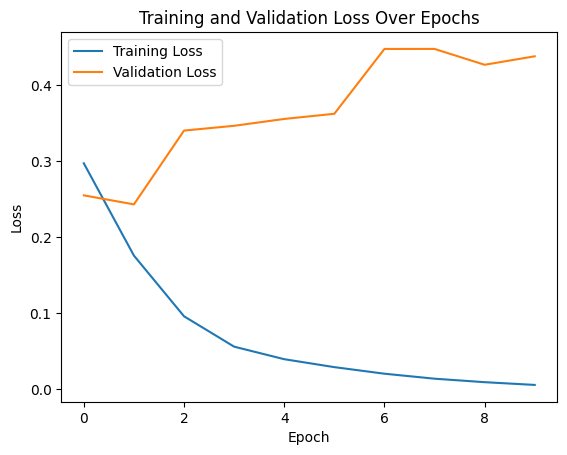

In [10]:
# Visualization
import matplotlib.pyplot as plt

plt.plot(train_stats['train_loss'], label='Training Loss')
plt.plot(train_stats['validation_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [11]:
# Save the current finetuned model with imdb
model_path = "finetune_bert_large_uncased.pth"

torch.save({
    "model_state_dict": bert_classifier.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "training_stats": train_stats
}, model_path)